In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
%config InlineBackend.figure_format = 'retina'

In [2]:
t_VVV_NGC6569 = Table.read('D:/Astronomy/aaaaawork/gaia/globular_cluster/NGC6569/NGC6569_vvv_all.fits',format='fits')

umag = t_VVV_NGC6569['umag']
gmag = t_VVV_NGC6569['gmag']
imag = t_VVV_NGC6569['imag']
rmag = t_VVV_NGC6569['rmag']
ra = t_VVV_NGC6569['ra']
dec = t_VVV_NGC6569['dec']
pmra = t_VVV_NGC6569['pmra']
pmra_error = t_VVV_NGC6569['pmra_error']
pmdec = t_VVV_NGC6569['pmdec']
pmdec_error = t_VVV_NGC6569['pmdec_error']
cluster_motion = t_VVV_NGC6569['dr2_radial_velocity']
bp = t_VVV_NGC6569['phot_bp_mean_mag']
rp = t_VVV_NGC6569['phot_rp_mean_mag']

In [3]:
error = (pmra_error<0.35) & (pmdec_error<0.35) 

pmra_cut = pmra[error]
pmdec_cut = pmdec[error]
umag_cut = umag[error]
gmag_cut = gmag[error]
rmag_cut = rmag[error]
imag_cut = imag[error]
ra_cut = ra[error]
dec_cut = dec[error]
bp_cut = bp[error]
rp_cut = rp[error]
ejk = t_VVV_NGC6569['EJKs']
ejk_cut = ejk[error]

In [4]:
#transform from VVV to 2MASS (the map is for VVV photometry)
ext2m = 1/0.925*ejk
#2MASS to EBV using the equations in Green+ 2018
ebv2 = ext2m/0.489

mean_ebv = np.mean(ebv2)
delta_ebv = ebv2 - mean_ebv

In [5]:
#summary all GCs
#in '/Users/iuliasimion/Library/Mobile Documents/com~apple~CloudDocs/GCs_zhen_iulia/data'
gc = Table.read("D:/Astronomy/aaaaawork/gaia/globular_cluster/GCs_bulge.fit")
np.array(gc.colnames)

#select a GC
ind_gc = gc["Name"] == b'NGC_6569      '
print(gc[ind_gc])

#basic GC parameters
rh = gc[ind_gc]['rh'][0]/60 #in degrees, rh = 0.8 arcmin
ra0 = gc[ind_gc]['ra_gaia'][0] #GC center
dec0 = gc[ind_gc]['dec_gaia'][0]

     Name       ra_gaia    dec_gaia   dist ... modelMass model_sig_v model_v_esc
-------------- ---------- ---------- ----- ... --------- ----------- -----------
NGC_6569       273.411666 -31.826888 10.49 ...  364000.0        11.3        40.6


In [6]:
rh

0.013333333532015483

In [7]:
gc[ind_gc]

Name,ra_gaia,dec_gaia,dist,disterr,vlos,vloserr,sigma,rmax,pmra,pmdec,pmra_e,pmdec_e,pmcorr,plx,plx_e,col17,per_1,per_2,per_3,apo_1,apo_2,apo_3,Jr_1,Jr_2,Jr_3,Jz_1,Jz_2,Jz_3,Jphi_1,Jphi_2,Jphi_3,Ener_1,Ener_2,Ener_3,Name_2,l,b,R_sun,R_galac,X,Y,Z,Fe_H,Reddening,V_HB,m_M_V,V_t,M_V_t,U-B,B-V,V-R,V-I,ellip,v_r,v_r_err,v_LSR,sig_v,sig_v_err,c,cc,rc,rh,mu_V,rho_0,lg_tc,lg_th,Gamma1,Gamma2,Gamma3,modelMass,model_sig_v,model_v_esc
bytes14,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int32,int32,int32,bytes14,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes2,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32
NGC_6569,273.411666,-31.826888,10.49,0.24,-49.83,0.5,7.1,4.0,-4.139,-7.356,0.027,0.027,0.009,0.102,0.011,329.132262199,1.71,1.93,2.23,2.56,2.77,3.08,8,8,9,88,89,90,-461,-388,-341,-221546,-217709,-212258,NGC_6569,0.4809,-6.6809,10.9,3.1,10.8,0.1,-1.3,-0.76,0.53,17.52,16.83,8.55,-8.28,0.74,1.34,0.83,1.69,0.0,-28.1,5.6,-20.3,--,--,1.31,,0.35,0.8,18.15,3.63,8.38,9.05,53.6,62.8,72.8,364000.0,11.3,40.6


In [8]:
import numpy as np
from math import *
from astropy.coordinates import SkyCoord
from scipy.ndimage import map_coordinates
from astropy import wcs
import astropy.units as units
from astropy.io import fits
from astropy.table import Table
import galpy.util.bovy_coords as gub

def get_extinction0(l,b):
    
    pixx, pixy = w.wcs_world2pix(l, b, 1)

    #Read the extinction value
    for mapd in mapds:
        ext = map_coordinates(mapd, [[pixy],[pixx]], order=0)  

    #transform from VVV to 2MASS (the map is for VVV photometry)
    ext2m = 1/0.925*ext[0] 

    #2MASS to EBV using the equations in Green+ 2018
    ebv2 = ext2m/0.489

    #Green et al. 2018
    Ag = 3.384*ebv2
    Ar = 2.483* ebv2
    Ai =  1.838 * ebv2
    Az =  1.414*ebv2
    Ay = 1.126*ebv2
    Au =  4.239*ebv2 #from Schlafly+ 2011
    
    redenning = np.vstack((Ag, Ar, Ai, Az, Ay, Au, ebv2)).T
    
    return redenning

In [9]:
#read extinction map
dustmapfn='D:/Astronomy/aaaaawork/gaia/globular_cluster/extmap_bulge.fits'
hdulist=fits.open(dustmapfn)
mapds=[hdulist[0].data]
w = wcs.WCS(hdulist[0].header)  

In [10]:
lb = gub.radec_to_lb(t_VVV_NGC6569["ra"], t_VVV_NGC6569["dec"],degree=True)
lon=lb[:,0]-360*(lb[:,0]>180)
lat = lb[:,1]
wh_rh = np.sqrt((t_VVV_NGC6569['ra']-ra0)**2. + (t_VVV_NGC6569['dec']-dec0)**2.) < 10*rh

In [11]:
#Read the map from Simion et al. 2017
bins = [200,150]
binx = bins[0]
biny = bins[1]
lmin = min(lon); lmax = max(lon); bmin = min(lat); bmax = max(lat)
l_ext, b_ext= np.mgrid[lmin:lmax:700j,bmin:bmax:500j]  #在l上生成 700 个均匀间隔的点
pixx, pixy = w.wcs_world2pix(l_ext,b_ext, 1)           #将l,b转换为像素坐标
for mapd in mapds:
    ext = map_coordinates(mapd,[[pixy],[pixx]], order=0)  

Ax = get_extinction0(lon,lat) 

EBV0 = np.mean(Ax[:,-1]) 

In [12]:
EBV0

0.31602022

Text(0.5, 1.0, 'NGC 6569 (BDBS)')

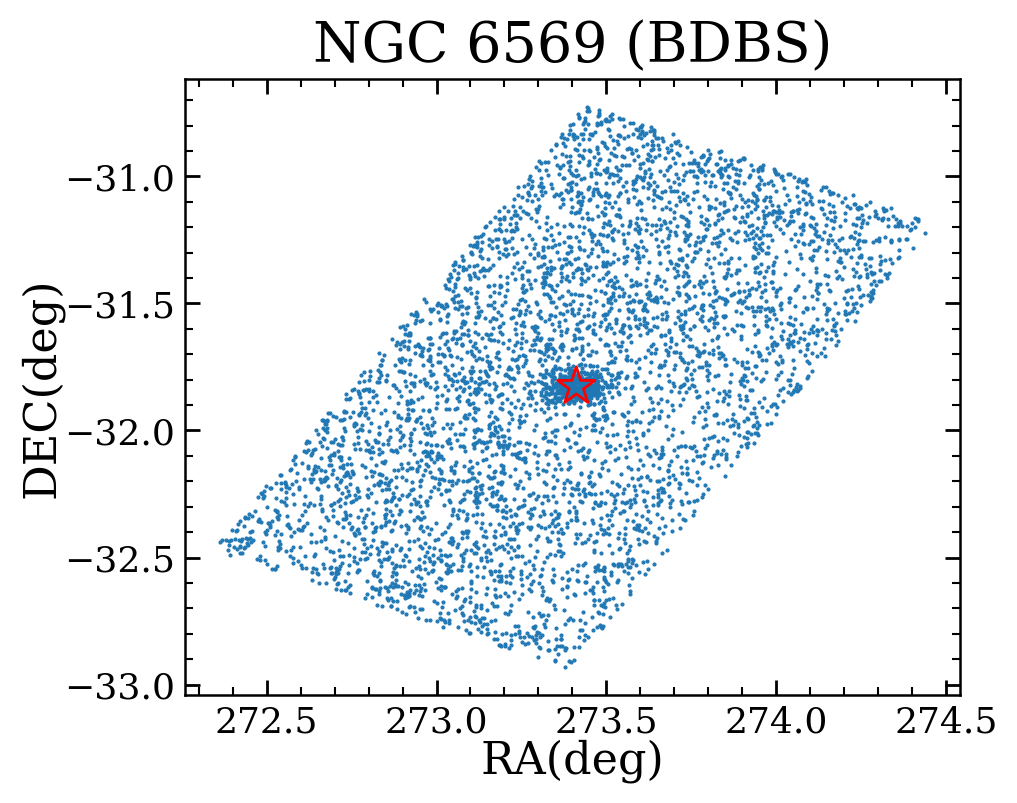

In [28]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (5,4))
plt.plot(t_VVV_NGC6569["ra"], t_VVV_NGC6569["dec"], ".", ms=1, alpha=1, zorder=0)
plt.scatter(gc["ra_gaia"][ind_gc], gc["dec_gaia"][ind_gc], 
        facecolor="None", edgecolor="r", marker="*", s=200, zorder=1)
plt.xlabel("RA(deg)")
plt.ylabel("DEC(deg)")
plt.title('NGC 6569 (BDBS)')

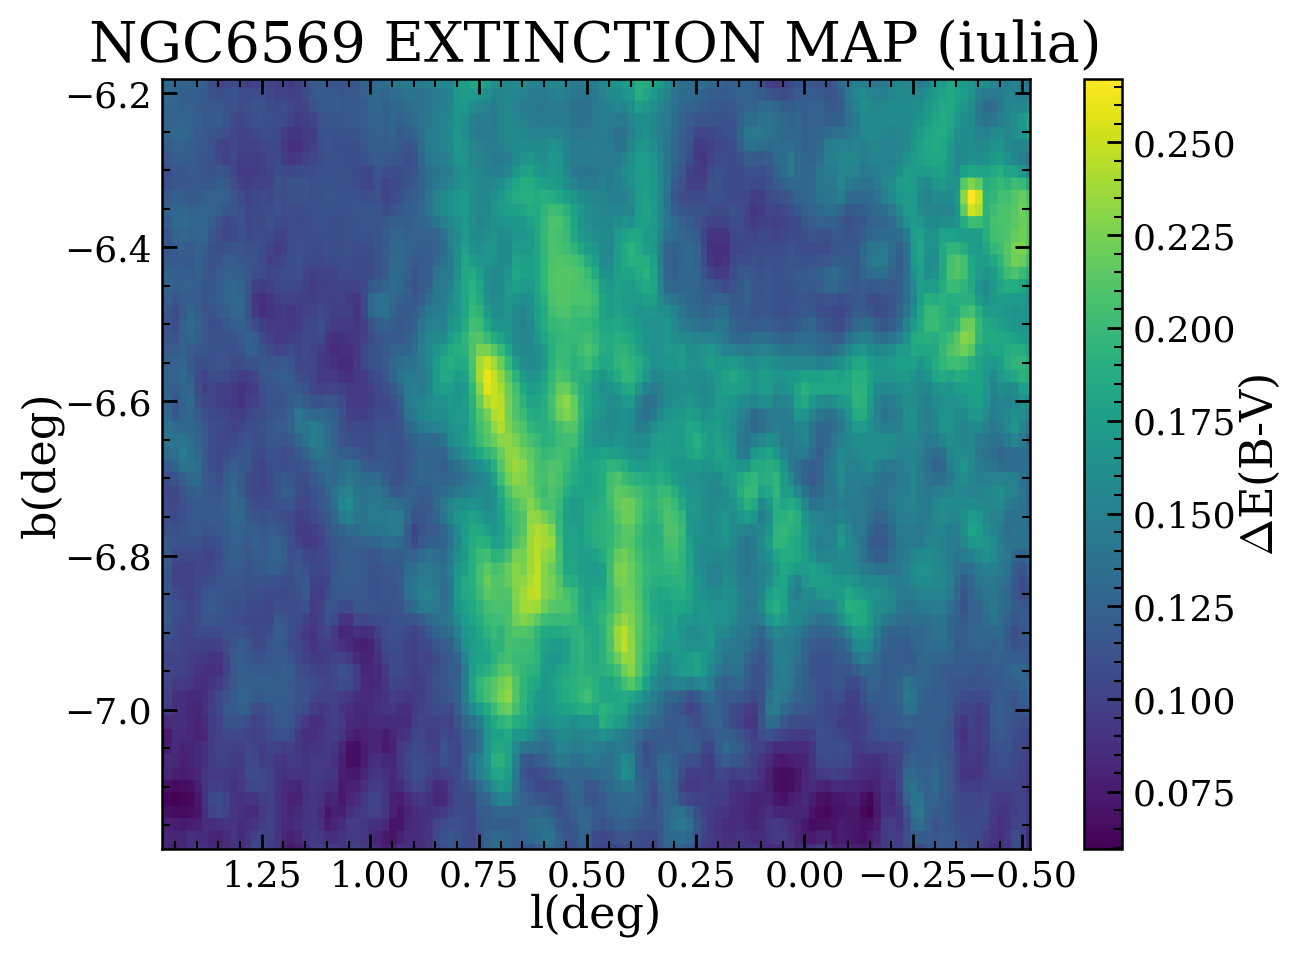

lmin: -0.518768405398589
lmax: 1.480433472503108


In [33]:
#extinction from Simion 
plt.figure(figsize=(7,5))
plt.imshow(np.rot90(ext[0]), extent=[lmin, lmax, bmin, bmax], aspect = 'auto') 
plt.xlim(lmax, lmin)
plt.xlabel('l(deg)')
plt.ylabel('b(deg)')
plt.title('NGC6569 EXTINCTION MAP (iulia)')
colorbar = plt.colorbar()
colorbar.set_label('$\Delta$E(B-V)')
plt.show()
print('lmin:',lmin)
print('lmax:',lmax)

In [15]:
from scipy.interpolate import griddata#Read the differential extinction from Justin 2021
#select GC members for which we have the differential extinction (within 10rh)
dust_diff='D:/Astronomy/aaaaawork/gaia/globular_cluster/NGC6569_diff_ext.fits'
hdulist_diff=fits.open(dust_diff)
map_diff=[hdulist_diff[0].data]
ra_diff = hdulist_diff[1].data['Radeg']
dec_diff = hdulist_diff[1].data['Dedeg']
dE = hdulist_diff[1].data['dE']
ebv_diff = griddata((ra_diff,dec_diff), dE, (t_VVV_NGC6569['ra'][wh_rh], t_VVV_NGC6569['dec'][wh_rh]), method='linear')
ebv = ebv_diff + EBV0
Ag_diff = 3.384*ebv
Ai_diff = 1.838*ebv
Au_diff = 4.239*ebv

Text(0.5, 1.0, 'NGC6569 (BDBS)')

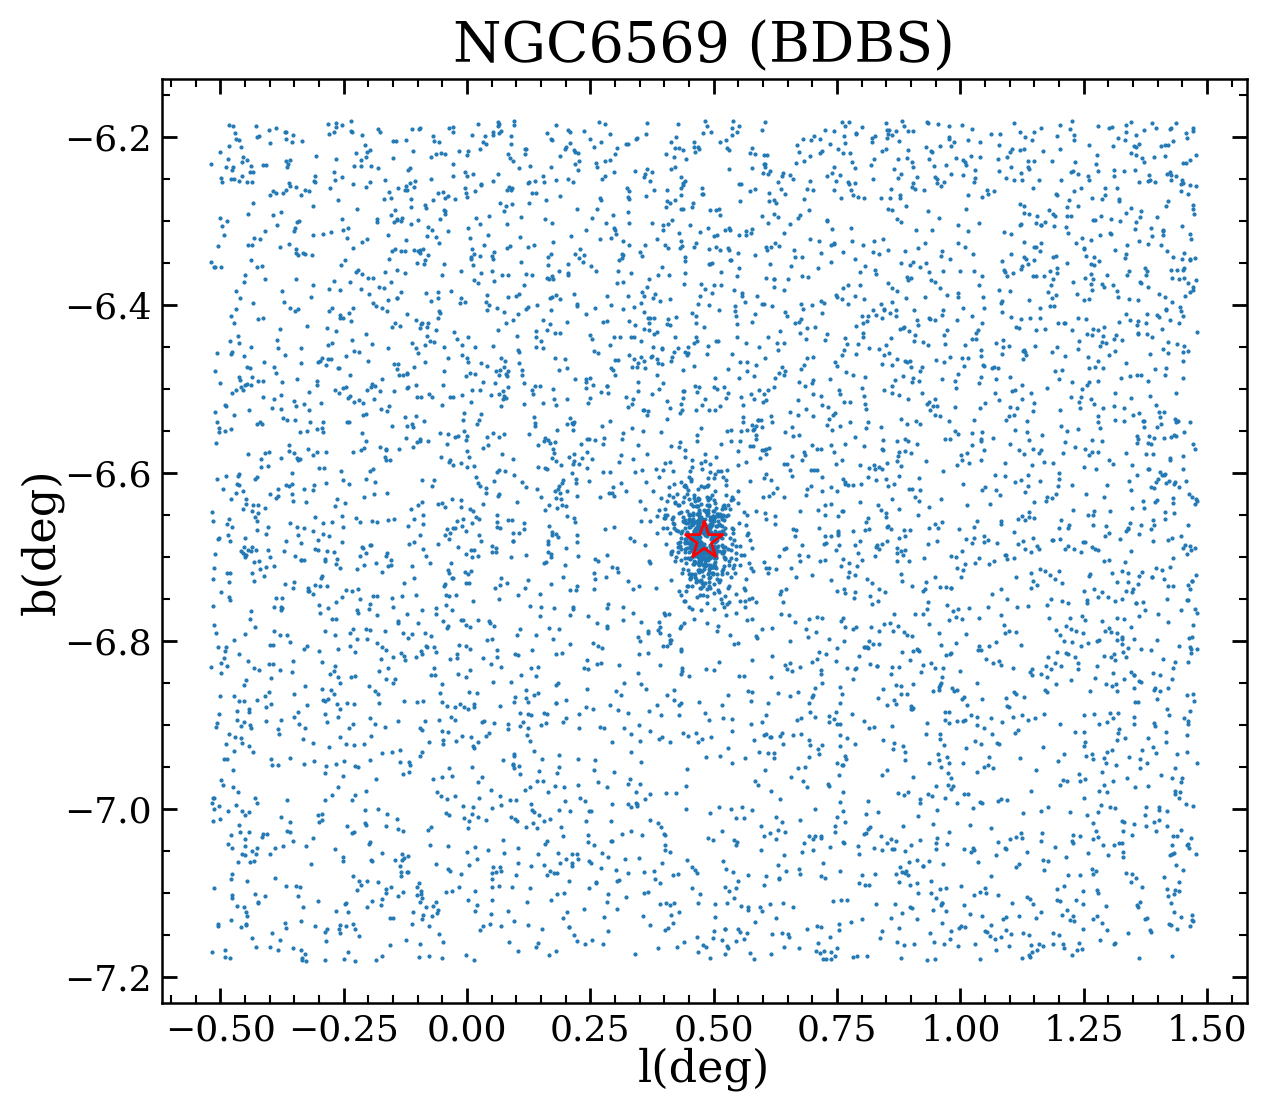

In [34]:
#plot lb
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (7,6))
plt.plot(lon, lat, ".", ms=1, alpha=1, zorder=0)
plt.scatter(gc["l"][ind_gc], gc["b"][ind_gc], 
        facecolor="None", edgecolor="r", marker="*", s=200, zorder=1)
plt.xlabel("l(deg)")
plt.ylabel("b(deg)")
plt.title('NGC6569 (BDBS)')
#plt.xlim(0.25,0.75)
#plt.ylim(-6.8,-6.6)

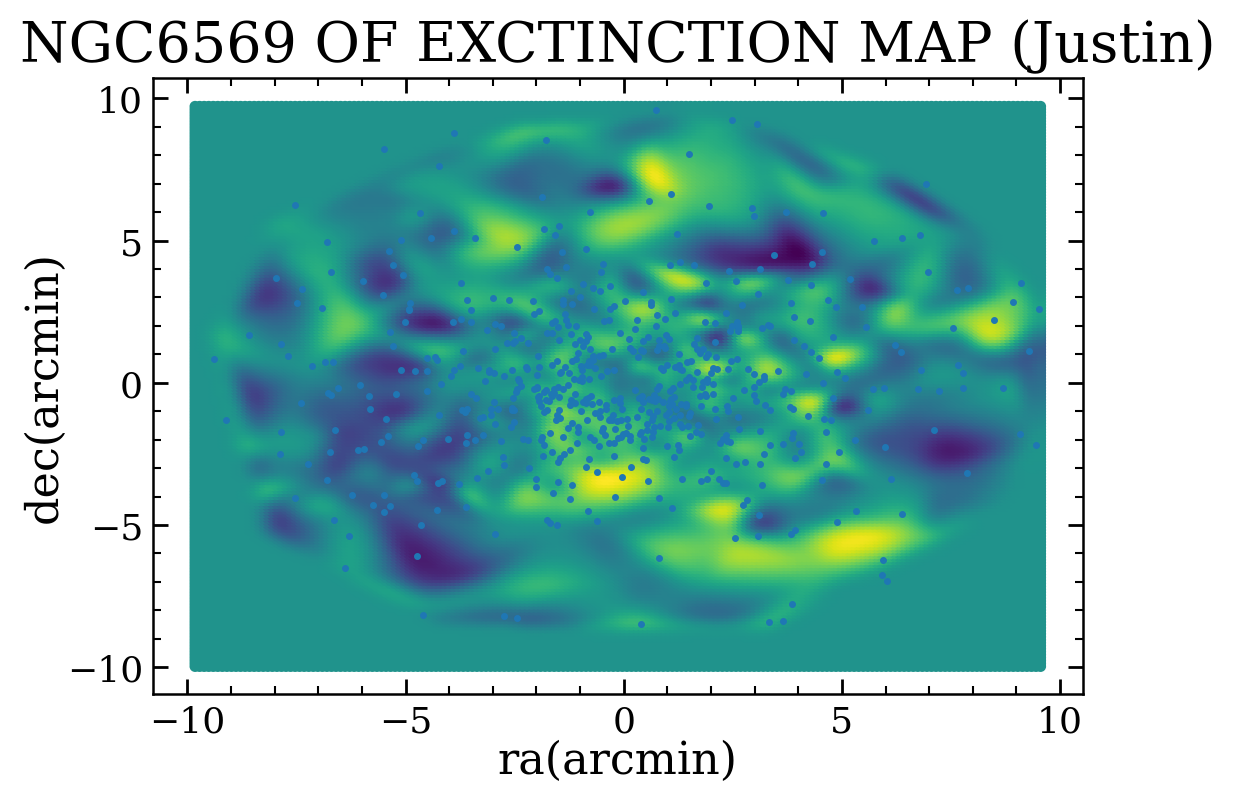

In [37]:
#Plot the differential extinction for NGC 6569
fig = plt.figure(figsize=(6, 4))
plt.scatter((ra_diff-ra0)*60/0.8, (dec_diff-dec0)*60/0.8, c = EBV0+dE)
plt.plot((t_VVV_NGC6569["ra"][wh_rh]-ra0)*60/0.8, (t_VVV_NGC6569["dec"][wh_rh]-dec0)*60/0.8,'.')
plt.plot()
plt.xlabel('ra(arcmin)')
plt.ylabel('dec(arcmin)')
plt.title('NGC6569 OF EXCTINCTION MAP (Justin)')
fig.savefig('NGC6569_diff_ext.png')
plt.show()

#Plot the CMD
plt.plot((t_VVV_NGC6569['gmag']-t_VVV_NGC6569['imag'])[wh_rh], t_VVV_NGC6569['imag'][wh_rh], '.', color = 'black', ms=  1, label = 'BDBS, 10rh')
plt.plot((t_VVV_NGC6569['gmag']-Ax[:,0])[wh_rh]-(t_VVV_NGC6569['imag']-Ax[:,2])[wh_rh], (t_VVV_NGC6569['imag']-Ax[:,2])[wh_rh], '.', color = 'red', ms=  1, label = 'Iulia map')
plt.plot((t_VVV_NGC6569['gmag'][wh_rh]-Ag_diff)-(t_VVV_NGC6569['imag'][wh_rh]-Ai_diff), (t_VVV_NGC6569['imag'][wh_rh]-Ai_diff), '.', color = 'green', ms=  1, label = 'Justin map, VVV zp')
plt.xlim(-0.5, 2.5)
plt.ylim(22,12)
plt.xlabel('g-i')
plt.ylabel('i')
plt.title('NGC 6569')
plt.legend()
plt.show()

try to download the hst data

In [18]:
from astroquery.esa.hubble import ESAHubble
from astropy import coordinates
esahubble = ESAHubble()
c = coordinates.SkyCoord("00h42m44.51s +41d16m08.45s", frame='icrs')
table = esahubble.query_target(name="m31", filename="m31_query.xml.gz")  
#table = esahubble.cone_search(coordinates=c, radius=7, filename="cone_search_m31_5.vot.gz")

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [19]:
esahubble = ESAHubble()
c = coordinates.SkyCoord("00h42m44.51s +41d16m08.45s", frame='icrs')
table = esahubble.cone_search(coordinates=c, radius=7, filename="cone_search_m31_5.vot.gz")

type: <class 'str'>


AttributeError: 'str' object has no attribute 'read'

In [91]:
#读取HST数据
from astropy.table import Table
NGC6569_hst=Table.read('D:/Astronomy/aaaaawork/gaia/globular_cluster/NGC6569/ngc6569_hst',format="fits")
print(NGC6569_hst)

 matchid       matchra             matchdec      ... w3_fq492n_mad w3_fq492n_n
                 deg                 deg         ...      mag                 
--------- ------------------ ------------------- ... ------------- -----------
    35567  273.5082037404799  -31.90464470481091 ...            --          --
   674064 273.49030034167356 -31.914023165934314 ...            --          --
  1024581  273.5108890290444 -31.905437320713126 ...            --          --
  1247989  273.5102088038157 -31.901405389829993 ...            --          --
  1794787  273.4896730457127 -31.914008245425947 ...            --          --
  2208754  273.4879385615102 -31.914324712236606 ...            --          --
  2651696 273.50842405380763  -31.90309404705475 ...            --          --
  2803095   273.510614289306 -31.904836167902907 ...            --          --
  2991404 273.51006620399846 -31.904781162609304 ...            --          --
  3166535  273.5081696132468 -31.905872298317988 ...

In [92]:
f336w = NGC6569_hst['w2_f336w']
f606w = NGC6569_hst['a_f606w']
f438w = NGC6569_hst['w3_f438w']
f814w = NGC6569_hst['w3_f814w']
f702w = NGC6569_hst['w2_f702w']
f160w = NGC6569_hst['w3_f160w']
f110w = NGC6569_hst['w3_f110w']
f439w = NGC6569_hst['w2_f439w']
f555w = NGC6569_hst['w2_f555w']
Eb_v = NGC6569_hst['extinction']
ra = NGC6569_hst['matchra']
dec = NGC6569_hst['matchdec']
time = NGC6569_hst['startmjd']
#cut = f702w > 0
#f336w_cut = f336w[cut]
A_f336w = Eb_v*4.453
A_f606w = Eb_v*2.471
A_f438w = Eb_v*3.623
A_f814w = Eb_v*1.336
A_f110w = Eb_v*0.881
A_f160w = Eb_v*0.512
A_f439w = Eb_v*3.623 #use the exctinction of WFC3 F438W
A_f555w = Eb_v*2.755

f336w_2 = f336w - A_f336w
f606w_2 = f606w - A_f606w
f438w_2 = f438w - A_f438w
f814w_2 = f814w - A_f814w
f110w_2 = f110w - A_f110w
f160w_2 = f160w - A_f160w
f439w_2 = f439w - A_f439w
f555w_2 = f606w - A_f606w
f336w_f606w = f336w_2 - f606w_2
f110w_f160w = f110w_2 - f160w_2
f439w_f555w = f439w_2 - f555w_2
f160w_f606w = f160w_2 - f606w_2
Cf336w_f438w_f814w = (f336w-f438w)-(f438w-f814w)

In [93]:
time

57609.605180446524
57609.605180446524
57609.605180446524
57609.605180446524
57609.605180446524
57609.605180446524
57609.605180446524
57609.605180446524
57609.605180446524
57609.605180446524
57609.605180446524


In [94]:
np.unique(time)

51695.43072714796
51695.43419942586
57510.825802703854
57510.82643936807
57609.60307904845
57609.605180446524
57609.61288858345


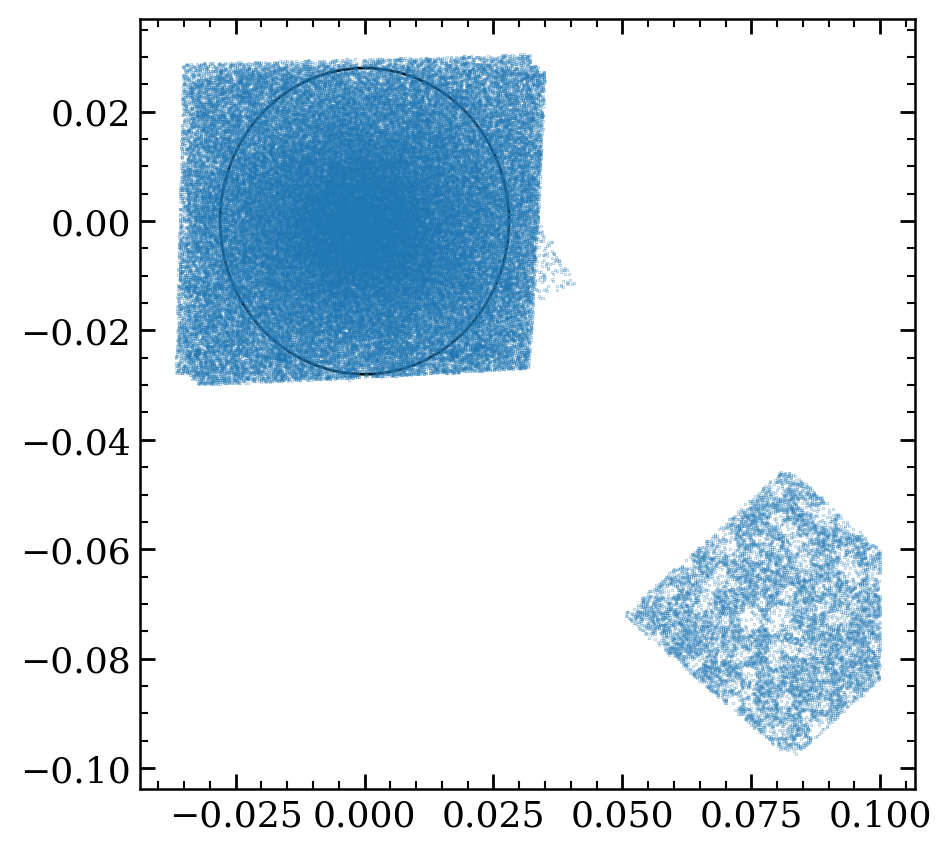

In [99]:
ra0=273.412
dec0=-31.826
plt.plot(ra-ra0,dec-dec0,'.',ms=0.2)
rad =  (ra-ra0)**2 + (dec-dec0)**2 
radec = rad<0.03**2 #rh=0.8arcmin =
ra_2 = ra[radec]
dec_2 = dec[radec]

circle = plt.Circle((0,0), 0.028, fill=False, color='black')
plt.gca().add_patch(circle)
#plt.scatter(ra0,dec0,c='red',s=3)
#plt.xlim(-0.03,0.03)
#plt.ylim(-0.03,0.03)

In [96]:
f336w_2_cut = f336w_2[radec]
f606w_2_cut =  f606w_2[radec]
f438w_2_cut =  f438w_2[radec]
f814w_2_cut =  f814w_2[radec]
f110w_2_cut =  f110w_2[radec]
f160w_2_cut =  f160w_2[radec]
f439w_2_cut =  f439w_2[radec]
f555w_2_cut =  f555w_2[radec]
time_2 = time[radec]
f110w_f160w_cut = f110w_2_cut - f160w_2_cut
f439w_f555w_cut = f439w_2_cut - f555w_2_cut
f160w_f606w_cut = f160w_2_cut - f606w_2_cut


In [108]:
#timecut = np.datetime64('57609.605180446524')

timecut = 57609.605180446524
time_cut = np.isclose(time_2, timecut)

print("time_2:", time_2)
print("timecut:", timecut)
print("time_cut:", time_cut)
print("time_cut indices:", np.where(time_cut)[0])

f160w_timecut = f160w_2_cut[time_cut]
f110w_timecut = f110w_2_cut[time_cut]
f606w_timecut = f606w_2_cut[time_cut]
f555w_timecut = f555w_2_cut[time_cut]
f439w_timecut = f439w_2_cut[time_cut]
f110w_f160w_timecut = f110w_timecut - f160w_timecut
f439w_f555w_timecut = f439w_timecut - f555w_timecut
f160w_f606w_timecut = f160w_timecut - f606w_timecut


time_2:      startmjd    
        d        
-----------------
57609.60307904845
57609.60307904845
57609.60307904845
57609.60307904845
57609.60307904845
57609.60307904845
57609.60307904845
57609.60307904845
57609.60307904845
57609.60307904845
              ...
57609.60307904845
57609.60307904845
51695.43072714796
57609.60307904845
57609.60307904845
57609.60307904845
57609.60307904845
57609.60307904845
57609.60307904845
57609.60307904845
Length = 67337 rows
timecut: 57609.605180446524
time_cut: [ True  True  True ...  True  True  True]
time_cut indices: [    0     1     2 ... 67334 67335 67336]


In [107]:
np.min(f110w_timecut)

masked

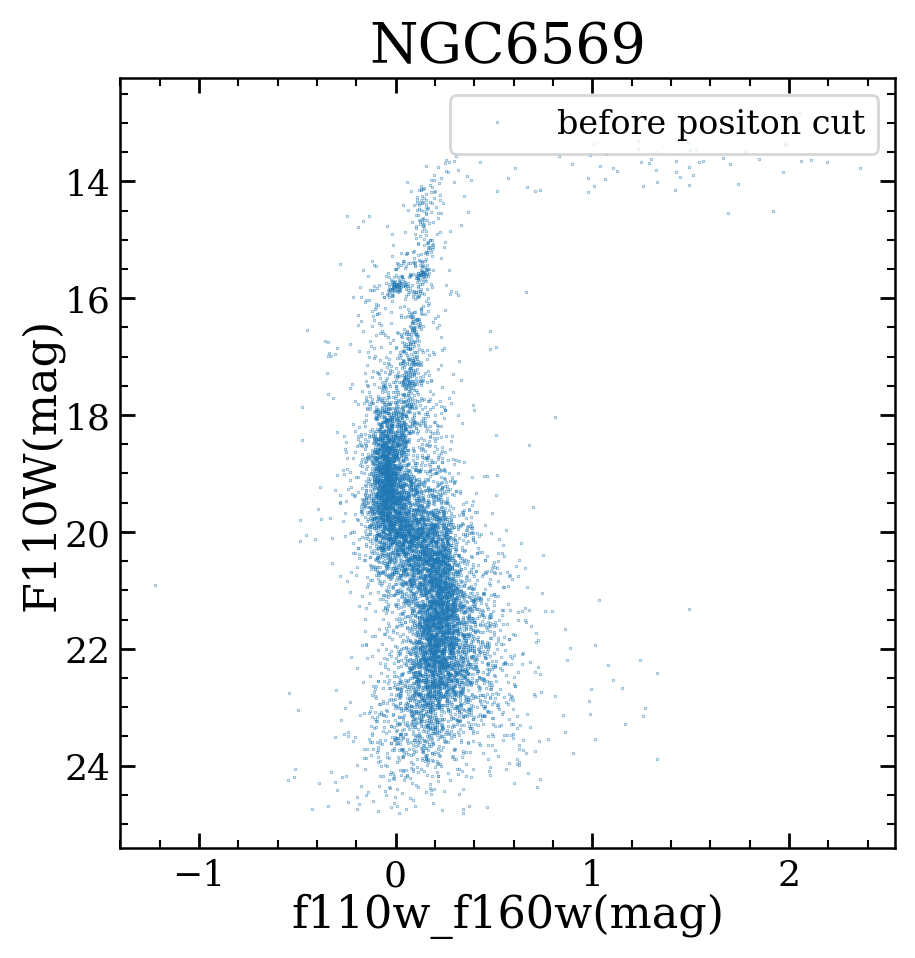

In [81]:
plt.style.use("D:/Astronomy/aaaaawork/gaia/globular_cluster/paper.mplstyle")
plt.plot(f110w_f160w,f160w_2,'.',ms=0.3,label='before positon cut')
#plt.plot(f110w_f160w_timecut,f160w_timecut,'.',ms=0.3,c='red',label='after position and time cut')
plt.xlabel('f110w_f160w(mag)')
plt.ylabel('F110W(mag)')
plt.legend(loc='upper right')
plt.title('NGC6569')
#plt.ylim(10,18)
#plt.xlim(0,6)
ax = plt.gca()  
ax.invert_yaxis() 

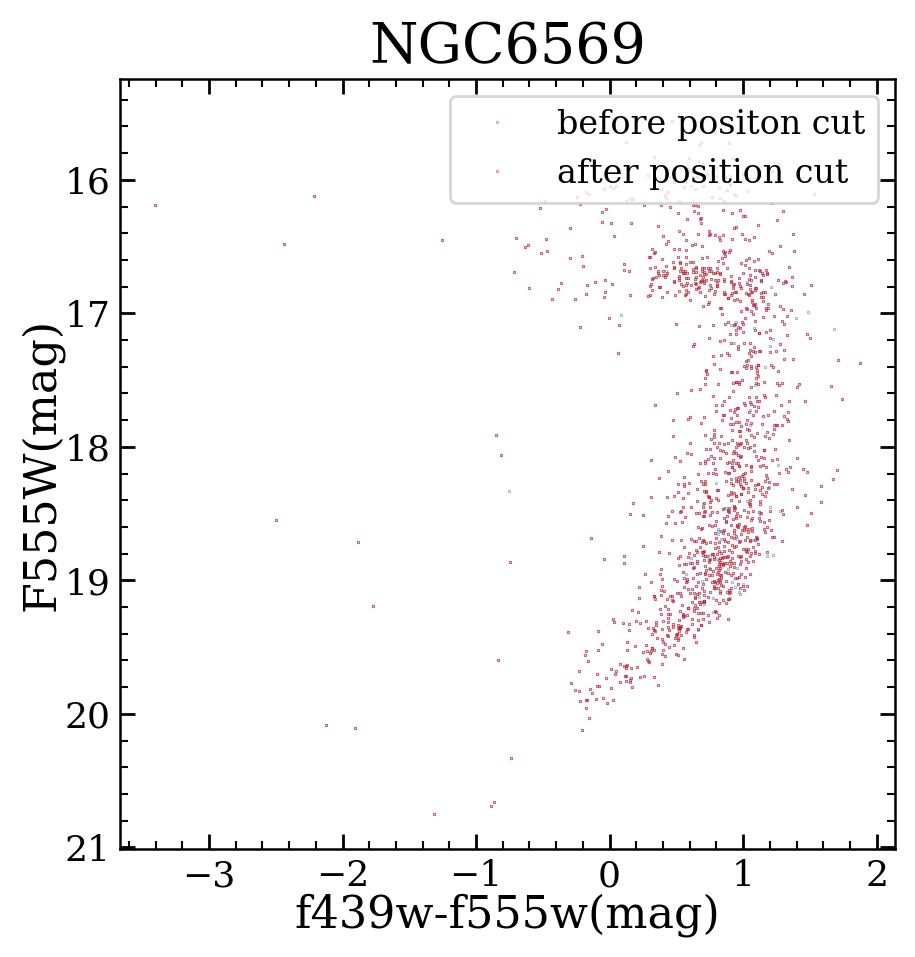

In [39]:
plt.style.use("D:/Astronomy/aaaaawork/gaia/globular_cluster/paper.mplstyle")
plt.plot(f439w_f555w,f555w_2,'.',ms=0.3,label='before positon cut')
plt.plot(f439w_f555w_cut,f555w_2_cut,'.',ms=0.3,c='red',label='after position cut')
plt.xlabel('f439w-f555w(mag)')
plt.ylabel('F555W(mag)')
plt.legend(loc='upper right')
plt.title('NGC6569')
#plt.ylim(10,18)
#plt.xlim(0,6)
ax = plt.gca()  
ax.invert_yaxis() 

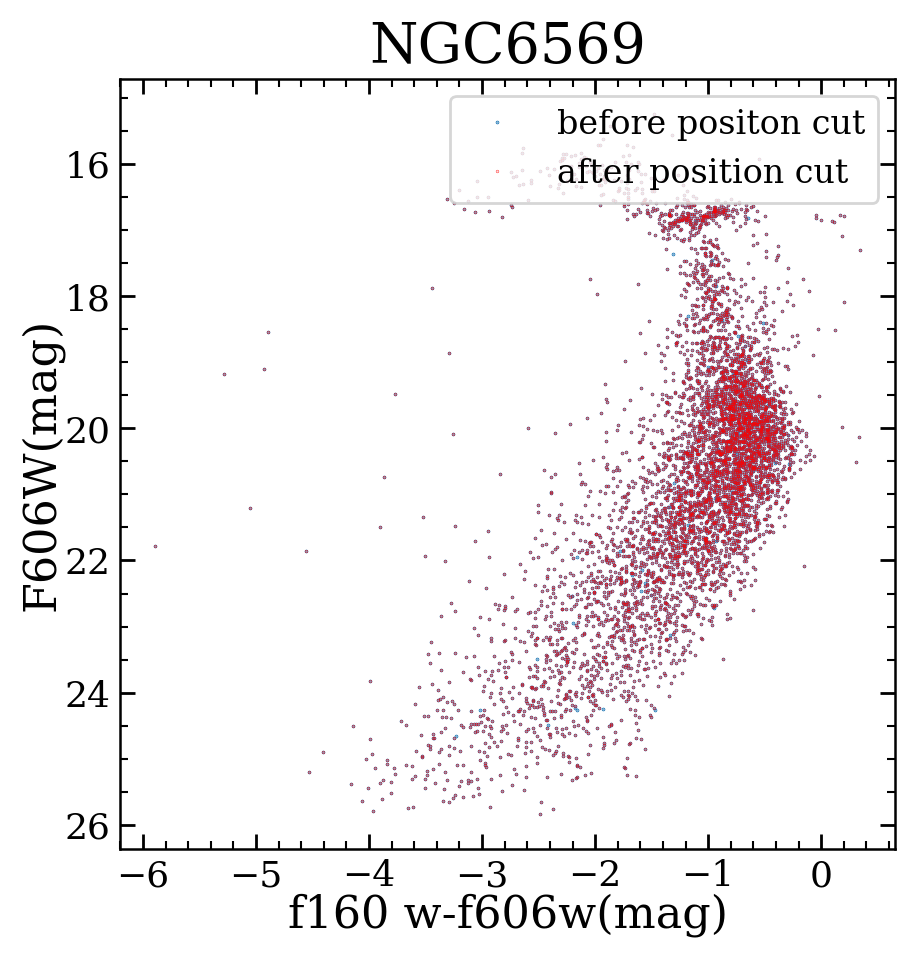

In [42]:
plt.style.use("D:/Astronomy/aaaaawork/gaia/globular_cluster/paper.mplstyle")
plt.plot(f160w_f606w,f606w_2,'.',ms=0.6,label='before positon cut')
plt.plot(f160w_f606w_cut,f606w_2_cut,'.',ms=0.3,c='red',label='after position cut')
plt.xlabel('f160 w-f606w(mag)')
plt.ylabel('F606W(mag)')
plt.legend(loc='upper right')
plt.title('NGC6569')
#plt.ylim(10,18)
#plt.xlim(0,6)
ax = plt.gca()  
ax.invert_yaxis() 

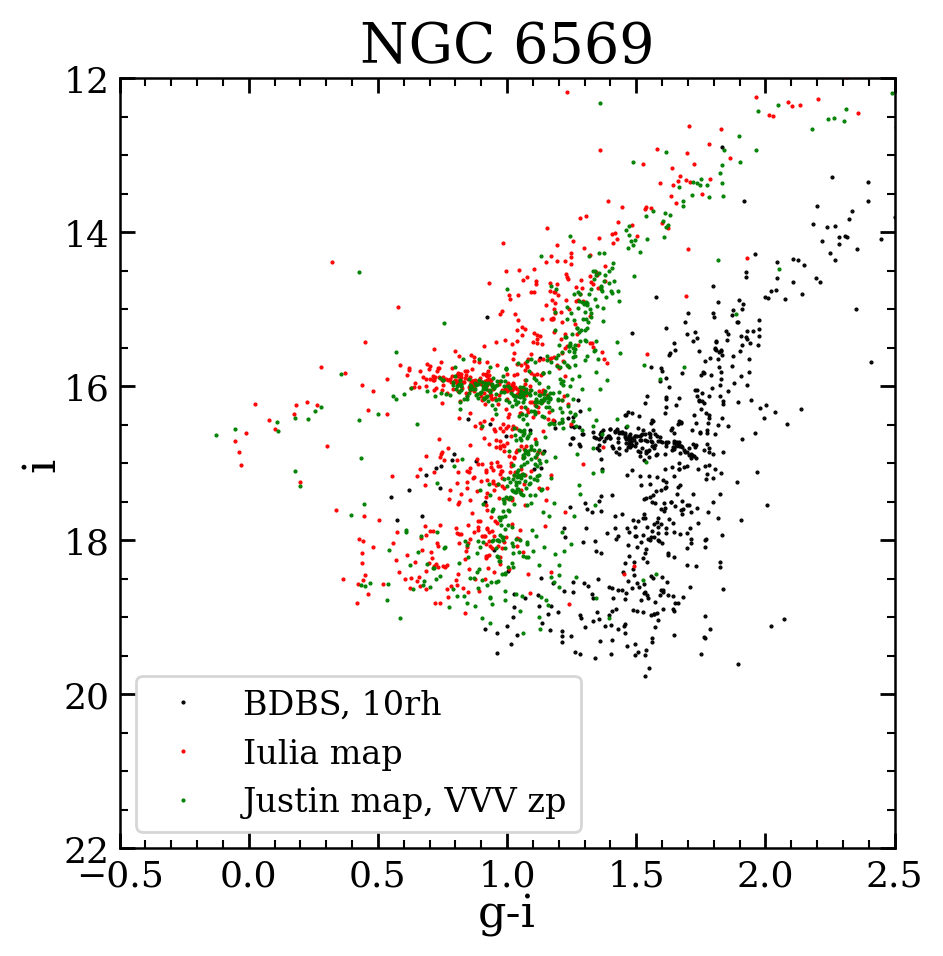

In [36]:
#Plot the CMD
plt.plot((t_VVV_NGC6569['gmag']-t_VVV_NGC6569['imag'])[wh_rh], t_VVV_NGC6569['imag'][wh_rh], '.', color = 'black', ms=  1, label = 'BDBS, 10rh')
plt.plot((t_VVV_NGC6569['gmag']-Ax[:,0])[wh_rh]-(t_VVV_NGC6569['imag']-Ax[:,2])[wh_rh], (t_VVV_NGC6569['imag']-Ax[:,2])[wh_rh], '.', color = 'red', ms=  1, label = 'Iulia map')
plt.plot((t_VVV_NGC6569['gmag'][wh_rh]-Ag_diff)-(t_VVV_NGC6569['imag'][wh_rh]-Ai_diff), (t_VVV_NGC6569['imag'][wh_rh]-Ai_diff), '.', color = 'green', ms=  1, label = 'Justin map, VVV zp')
plt.xlim(-0.5, 2.5)
plt.ylim(22,12)
plt.xlabel('g-i')
plt.ylabel('i')
plt.title('NGC 6569')
plt.legend()
plt.show()


In [ ]:
fig = plt.figure(figsize = (5,4))
plt.plot(t_VVV_NGC6569["ra"], t_VVV_NGC6569["dec"], ".", ms=1, alpha=1, zorder=0,c='red')

plt.scatter(gc["ra_gaia"][ind_gc], gc["dec_gaia"][ind_gc], 
        facecolor="None", edgecolor="r", marker="*", s=200, zorder=1)
plt.xlabel("RA(deg)")
plt.ylabel("DEC(deg)")
plt.title('NGC 6569 (BDBS)')